# Kaggle Competition: Store Sales - Time Series Forecasting
### Goal:  Build a model that more accurately predicts the unit sales for thousands of items sold at different stores
* Predicting the 'sales' variable
### Evaluation Metric:  Root Mean Squared Logarithmic Error (RMSLE)
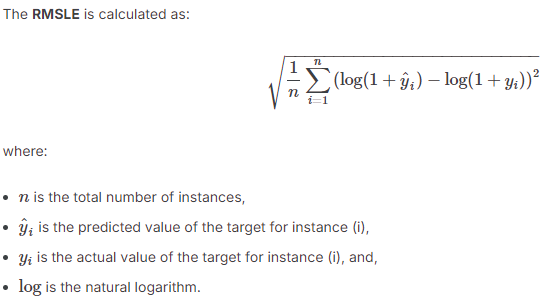

In [50]:
# General
import gc
import numpy as np
import pandas as pd
import polars as pl
import re
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from IPython.display import display, HTML

# Feature Selection
from scipy.stats import chi2_contingency, kruskal, pointbiserialr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import plot_importance

# Models
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Multi-thread
from multiprocessing import Pool

In [52]:
# Ferdinand Berr's Imports: https://www.kaggle.com/code/ferdinandberr/darts-forecasting-deep-learning-global-models
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import LightGBMModel, CatBoostModel, Prophet, RNNModel, TFTModel, NaiveSeasonal, ExponentialSmoothing, NHiTSModel
from darts.metrics import mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values
# from darts.models import MovingAverage
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.models.forecasting.baselines import NaiveMovingAverage


import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from tqdm import tqdm

In [ ]:
# holidays_events = pd.read_csv('data/holidays_events.csv')
# holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events = pl.read_csv('data/holidays_events.csv')
holidays_events = holidays_events.with_columns(pl.col('date').str.to_date("%Y-%m-%d"))

# oil = pd.read_csv('data/oil.csv')
# oil['date'] = pd.to_datetime(oil['date'])
oil = pl.read_csv('data/oil.csv')
oil = oil.with_columns(pl.col('date').str.to_date("%Y-%m-%d"))

# stores = pd.read_csv('data/stores.csv')
stores = pl.read_csv('data/stores.csv')

# transactions = pd.read_csv('data/transactions.csv')
# transactions['date'] = pd.to_datetime(transactions['date'])
transactions = pl.read_csv('data/transactions.csv')
transactions = transactions.with_columns(pl.col('date').str.to_date("%Y-%m-%d"))

# train = pd.read_csv('data/train.csv')
# train['date'] = pd.to_datetime(train['date'])
train = pl.read_csv('data/train.csv')
train = train.with_columns(pl.col('date').str.to_date("%Y-%m-%d"))

# test = pd.read_csv('data/test.csv')
# test['date'] = pd.to_datetime(test['date'])
test = pl.read_csv('data/test.csv')
test = test.with_columns(pl.col('date').str.to_date("%Y-%m-%d"))

sample_submission = pd.read_csv('data/sample_submission.csv')

## column types
# id - identifier
# date - time series
# store_nbr - categorical
# family - categorical
# sales - continuous
# onpromotion - continuous
# event_type - categorical
# locale - categorical
# locale_name - categorical
# description - categorical
# transferred - categorical (bool)
# dcoilwtico - continuous
# transactions - continuous
# city - categorical
# state - categorical
# store_type - categorical
# cluster - categorical

In [197]:
# Merge Together
holidays_events_encoded = holidays_events.to_dummies(columns=['type', 'locale', 'locale_name', 'description']).group_by('date').agg(pl.all().max())
stores_encoded = stores.rename({"type": "store_type"}).to_dummies(columns=['city', 'state', 'store_type', 'cluster'])

train_all = (train
             .join(holidays_events_encoded, on="date", how="left")
             .join(stores_encoded, on="store_nbr", how="left")
             .join(oil.fill_null(0), on="date", how="left")
             .join(transactions, on=["date", "store_nbr"], how="left")
             )

In [200]:
# Filling in null values created by missing dates
def fill_oil(df, column_name):
    df = df.sort("date")
    forward_filled = df[column_name].fill_null(strategy="forward")
    backward_filled = df[column_name].fill_null(strategy="backward")
    avg = (forward_filled + backward_filled) / 2
    avg = avg.fill_null(strategy="backward").fill_null(strategy="forward")
    return df.with_columns(avg.alias(column_name))

holidays_events_encoded_cols = [he_col for he_col in holidays_events_encoded.columns if he_col not in ['date', 'transferred']]

# train_all[holidays_events_cols] = train_all[holidays_events_cols].fill_null(value=0)

train_all = train_all.with_columns(
    [pl.col(col).fill_null(0) for col in holidays_events_encoded_cols] +
    [pl.col("transferred").fill_null(False)] +
    [pl.col("transactions").fill_null(0)]
)
train_all = fill_oil(train_all, 'dcoilwtico')

train_all_encoded = train_all.to_dummies(columns=['store_nbr', 'family'])

train_all_encoded = train_all_encoded.with_columns([
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.day().alias("day")
])
# train_all_encoded = train_all_encoded.drop("date")

new_column_names = {}
for col in train_all_encoded.columns:
    new_name = col.replace("+", "_plus").replace("-", "_min")
    new_name = re.sub(r'[^\w]', '_', new_name)
    
    if new_name in new_column_names.values():
        i = 1
        while f"{new_name}_{i}" in new_column_names.values():
            i += 1
        new_name = f"{new_name}_{i}"
    
    new_column_names[col] = new_name

train_all_encoded = train_all_encoded.rename(new_column_names)

# Lagging Features
cont_cols = ['onpromotion', 'dcoilwtico', 'transactions']
lags = [1, 5]
lagged_cols = [f"{col}_t{t}" for col in cont_cols for t in lags]

train_all_encoded = (train_all_encoded
                     .sort('date')
                     .with_columns(
                         [
                             pl.col(col).shift(t).fill_null(strategy='backward').alias(f'{col}_t{t}')
                             for col in cont_cols
                             for t in lags
                         ]
                     )
)

In [201]:
# Check formatting and nulls
special_character_columns = [col for col in train_all_encoded.columns if "+" in col or "-" in col]
print(f"Columns with +,-: {special_character_columns}")

columns_with_nan = [col for col in train_all_encoded.columns if train_all_encoded.select(pl.col(col).is_null().any()).item()]
print(f"\ncolumns_with_nan: {len(columns_with_nan)}")

train_all_encoded.filter(
    pl.any_horizontal(pl.all().is_null())
)

Columns with +,-: []

columns_with_nan: 0


id,date,store_nbr_1,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_2,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_3,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_4,store_nbr_40,…,state_Pichincha,state_Santa_Elena,state_Santo_Domingo_de_los_Tsachilas,state_Tungurahua,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,dcoilwtico,transactions,year,month,day,onpromotion_t1,onpromotion_t5,dcoilwtico_t1,dcoilwtico_t5,transactions_t1,transactions_t5
i64,date,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,i64,i32,i8,i8,i64,i64,f64,f64,i64,i64


# Correlation

https://datascience.stackexchange.com/questions/81618/is-it-better-to-correlate-and-encode-or-encode-and-correlate

Need to use different correlation tests for different types of variables

In [ ]:
## continuous variables
cont_cols = ['id', 'date', 'onpromotion',  'dcoilwtico', 'transactions', 'sales'] + lagged_cols
train_all_cont = train_all_encoded[cont_cols]

# Pearson test 
train_all_pearson = train_all_cont.corr()
# print(f'Pearson Correlation: \n{train_all_pearson}\n')

# Spearmans test
# https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide/notebook#3.-Transactions
train_all_spearman_data = {}

for i, col1 in enumerate(train_all_cont.columns):
    train_all_spearman_data[col1] = []
    for col2 in train_all_cont.columns:
        if col1 == "date" or col2 == "date":
            train_all_spearman_data[col1].append(0)
            continue
        corr_value = train_all_cont.select(
            pl.corr(pl.col(col1), pl.col(col2), method='spearman')
        ).item()
        train_all_spearman_data[col1].append(corr_value)

train_all_spearman = pl.DataFrame(train_all_spearman_data, schema=train_all_cont.columns)

# # In this case, faster to do Spearmans in Pandas
# train_all_pd = train_all_cont.to_pandas()
# train_all_spearman_pd = train_all_pd.corr(method='spearman')

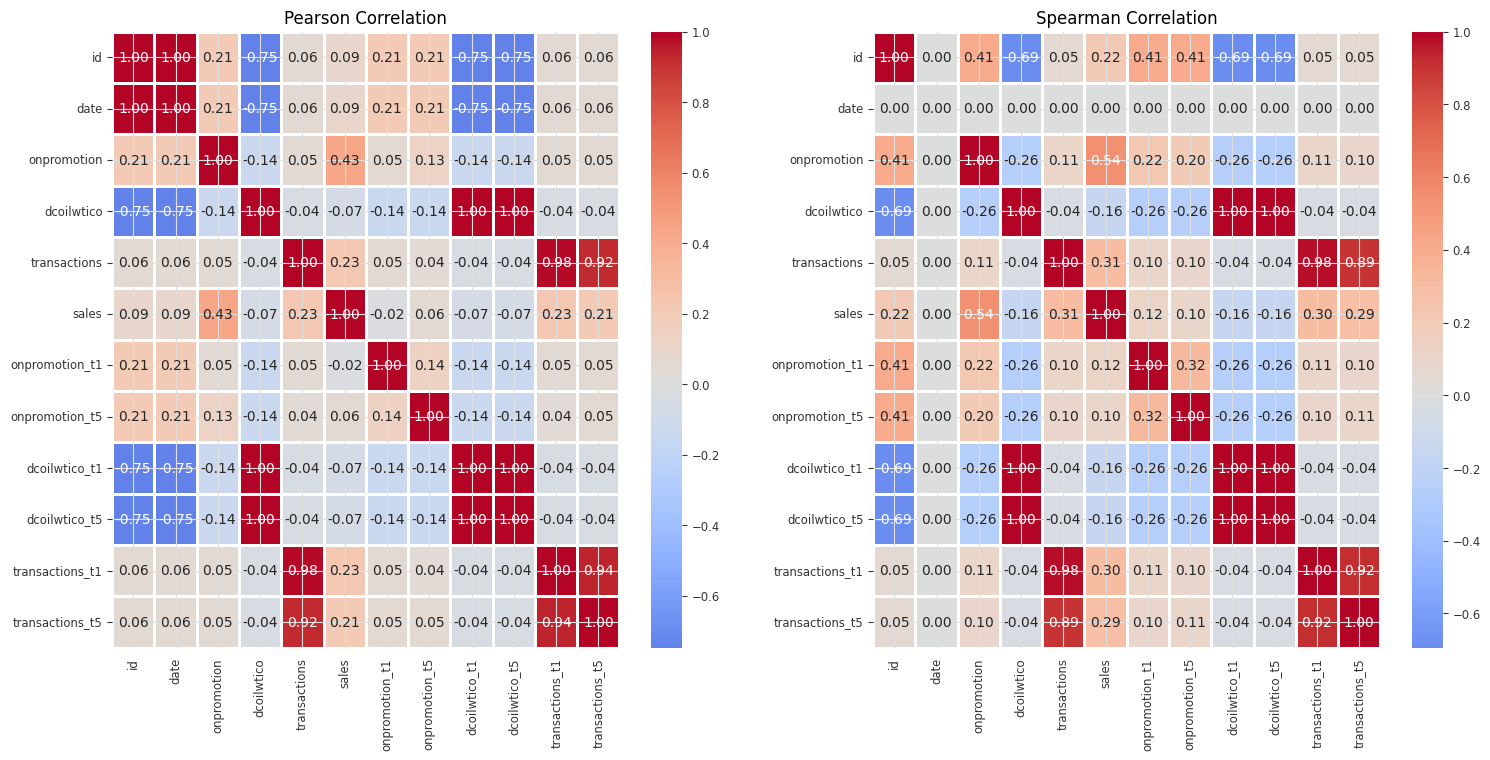

In [188]:
fig, ax = plt.subplots(1,2,figsize=(18,8))

sns.heatmap(
    data=train_all_pearson,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=1,
    center=0,
    xticklabels=train_all_pearson.columns,
    yticklabels=train_all_pearson.columns,
    ax=ax[0]
    )

sns.heatmap(
    data=train_all_spearman,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=1,
    center=0,
    xticklabels=train_all_pearson.columns,
    yticklabels=train_all_pearson.columns,
    ax=ax[1]
    )

ax[0].set_title('Pearson Correlation')
ax[1].set_title('Spearman Correlation')

plt.show()

In [215]:
train_all_forCorr = (train
                     .join(holidays_events, on="date", how="left")
                     .join(stores.rename({"type": "store_type"}), on="store_nbr", how="left")
                     .join(oil.fill_null(0), on="date", how="left")
                     .join(transactions, on=["date", "store_nbr"], how="left")
                     )

train_all_forCorr = fill_oil(train_all_forCorr, 'dcoilwtico')

train_all_forCorr = train_all_forCorr.with_columns(
    [pl.col("family").fill_null("None")] +
    [pl.col("type").fill_null("None")] + 
    [pl.col("locale").fill_null("None")] +
    [pl.col("locale_name").fill_null("None")] +
    [pl.col("description").fill_null("None")] + 
    [pl.col("transferred").fill_null(False)] +
    [pl.col("transactions").fill_null(0)]
)
# slower merge & cleaning than with the encoded dataframes because Polars deals with strings differently/slower

In [216]:
# Null check
columns_with_nan = [col for col in train_all_forCorr.columns if train_all_forCorr.select(pl.col(col).is_null().any()).item()]
print(f"\ncolumns_with_nan: {len(columns_with_nan), columns_with_nan}")

train_all_forCorr.filter(
    pl.any_horizontal(pl.all().is_null())
)


columns_with_nan: (0, [])


id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,city,state,store_type,cluster,dcoilwtico,transactions
i64,date,i64,str,f64,i64,str,str,str,str,bool,str,str,str,i64,f64,i64


In [ ]:
# Cat-Cat analysis
def chi_square_test(contingency_table):
    """Performs Chi-square test on a contingency table."""
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected

def cramers_v(contingency_table):
    """Calculates Cramer's V for a contingency table."""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

train_all_cat = train_all_forCorr[['id', 'date', 'store_nbr', 'family', 'type', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'store_type', 'cluster']]

contingency = (
    train_all_cat.group_by(["store_nbr", "family"])
    .agg(pl.count().alias("count"))
    .pivot(values="count", index="store_nbr", columns="family", aggregate_function="sum")
    .fill_null(0)
)

chi2_result = chi_square_test(contingency.select(pl.exclude("store_nbr")).to_numpy())
print(f'Chi-square: {chi2_result[0]:.2f}, p-value: {chi2_result[1]:.4f}')

v = cramers_v(contingency.select(pl.exclude("store_nbr")).to_numpy())
print(f"Cramer's V: {v:.4f}")

Chi-square: 0.00, p-value: 1.0000
Cramer's V: 0.0000


C:\Users\yangt\AppData\Local\Temp\ipykernel_26520\2176077145.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
C:\Users\yangt\AppData\Local\Temp\ipykernel_26520\2176077145.py:17: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(values="count", index="store_nbr", columns="family", aggregate_function="sum")


In [ ]:
# Anova for cat-cont
anova_model = ols('sales ~ C(family)', data=train).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(f"ANOVA for sales ~ family: \n{anova_table}\n")

In [221]:
categorical_cols = ['store_nbr', 'family', 'type', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'store_type', 'cluster']

# 2. Bin continuous target variable into categories (if needed)
train_all_cat = train_all_forCorr.with_columns(
    pl.col("sales").qcut(4, labels=["low", "medium", "high", "very_high"]).alias("sales_category")
)

# 3. Chi-square & Cramer's V calculation functions
def calculate_chi2_cramersv(df, feature, target="sales_category"):
    # Create contingency table
    contingency = (
        df.group_by([feature, target])
        .agg(pl.count().alias("count"))
        .pivot(values="count", index=feature, columns=target, aggregate_function="sum")
        .fill_null(0)
    )
    
    # Extract numpy array (exclude feature column)
    obs = contingency.select(pl.exclude(feature)).to_numpy()
    
    # Chi-square test
    chi2, p, dof, _ = chi2_contingency(obs)
    
    # Cramer's V calculation
    n = obs.sum()
    phi2 = chi2 / n
    r, k = obs.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    return chi2, p, cramers_v

# 4. Calculate for all categorical features
results = []
for col in categorical_cols:
    chi2, p_val, cramers_v = calculate_chi2_cramersv(train_all_cat, col)
    results.append({
        "feature": col,
        "chi2": chi2,
        "p_value": p_val,
        "cramers_v": cramers_v
    })

# 5. Create results DataFrame
results_df = pl.DataFrame(results).sort("cramers_v", descending=True)
print("Feature Ranking by Association Strength:")
print(results_df)

C:\Users\yangt\AppData\Local\Temp\ipykernel_26520\1741235774.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
C:\Users\yangt\AppData\Local\Temp\ipykernel_26520\1741235774.py:14: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(values="count", index=feature, columns=target, aggregate_function="sum")


Feature Ranking by Association Strength:
shape: (11, 4)
┌─────────────┬───────────────┬─────────────┬───────────┐
│ feature     ┆ chi2          ┆ p_value     ┆ cramers_v │
│ ---         ┆ ---           ┆ ---         ┆ ---       │
│ str         ┆ f64           ┆ f64         ┆ f64       │
╞═════════════╪═══════════════╪═════════════╪═══════════╡
│ family      ┆ 3.3411e6      ┆ 0.0         ┆ 0.603838  │
│ store_nbr   ┆ 376675.0726   ┆ 0.0         ┆ 0.202709  │
│ city        ┆ 187982.528978 ┆ 0.0         ┆ 0.143208  │
│ state       ┆ 158498.949679 ┆ 0.0         ┆ 0.131502  │
│ cluster     ┆ 149201.42055  ┆ 0.0         ┆ 0.127584  │
│ …           ┆ …             ┆ …           ┆ …         │
│ description ┆ 32680.149307  ┆ 0.0         ┆ 0.059443  │
│ type        ┆ 4725.01524    ┆ 0.0         ┆ 0.022665  │
│ locale_name ┆ 1642.768983   ┆ 1.9545e-295 ┆ 0.013093  │
│ locale      ┆ 660.129894    ┆ 2.5626e-136 ┆ 0.00843   │
│ transferred ┆ 75.712615     ┆ 2.5490e-16  ┆ 0.004879  │
└─────────────┴─

In [ ]:
# Chi-square and Cramer's V for Cat-Cat
train_contingency = pd.crosstab(train['store_nbr'], train['family'])
train_chi2, train_chi2_p, train_chi2_dof, train_chi2_exp = chi2_contingency(train_contingency)
print(f'Chi-square statistic: {train_chi2}\np-value: {train_chi2_p}\n')

train_crV_n = train_contingency.sum().sum()
train_crV_phi2 = train_chi2 / train_crV_n
train_crV_r, train_crV_k = train_contingency.shape
train_crV_phi2corr = max(0, train_crV_phi2 - ((train_crV_k-1) * (train_crV_r-1)) / (train_crV_n-1))
train_crV_rcorr = train_crV_r - ((train_crV_r-1)**2) / (train_crV_n-1)
train_crV_kcorr = train_crV_k - ((train_crV_k-1)**2) / (train_crV_n-1)
train_crV = np.sqrt(train_crV_phi2corr / min((train_crV_kcorr-1), (train_crV_rcorr-1)))
print(f"Cramer's V: {train_crV}\n")

# Anova for cat-cont
anova_model = ols('sales ~ C(family)', data=train).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(f"ANOVA for sales ~ family: \n{anova_table}\n")

Pearson Correlation: 
                   id      date  onpromotion     sales
id           1.000000  1.000000     0.206260  0.085784
date         1.000000  1.000000     0.206243  0.085728
onpromotion  0.206260  0.206243     1.000000  0.427923
sales        0.085784  0.085728     0.427923  1.000000

Chi-square statistic: 0.0
p-value: 1.0

Cramer's V: 0.0

ANOVA for sales ~ family: 
                 sum_sq         df            F  PR(>F)
C(family)  1.810352e+12       32.0  92571.48346     0.0
Residual   1.833922e+12  3000855.0          NaN     NaN



In [ ]:
# Kruskal-Wallis
family_groups = [train[train.family == family]['sales'] for family in train.store_nbr.unique()]
kw_stat, kw_p = kruskal(*family_groups)
print(f"Kruskal-Wallis for sales ~ family: \nstatistic: {kw_stat}\np-value: {kw_p}\n")

store_groups = [train[train.store_nbr == store_nbr]['sales'] for store_nbr in train.store_nbr.unique()]
kw_stat, kw_p = kruskal(*store_groups)
print(f"Kruskal-Wallis for sales ~ family: \nstatistic: {kw_stat}\np-value: {kw_p}\n")

# Run time of 10m 23.9s

# Some values of "family" have too few samples, should not include them

C:\Users\yangt\AppData\Local\Temp\ipykernel_37140\4010694148.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kw_stat, kw_p = kruskal(*family_groups)


Kruskal-Wallis for sales ~ family: 
statistic: nan
p-value: nan

Kruskal-Wallis for sales ~ family: 
statistic: 266880.4611403738
p-value: 0.0



In [56]:
train['family'].value_counts(ascending=False)

family
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION          

In [5]:
# Variance inflation factor check for multicollinearity
train_encoded = pd.get_dummies(train, columns=['store_nbr','family'])
X = train_encoded.drop(['id','date','sales'],axis=1)
y = train['sales']
model = LassoCV(cv=5).fit(X, y)
selected_features = X.columns[model.coef_ != 0]
print("Selected Features:", selected_features)

Selected Features: Index(['onpromotion', 'store_nbr_3', 'store_nbr_44', 'store_nbr_45',
       'store_nbr_46', 'store_nbr_47', 'store_nbr_49', 'family_BEVERAGES',
       'family_BREAD/BAKERY', 'family_CLEANING', 'family_DAIRY',
       'family_GROCERY I', 'family_POULTRY', 'family_PRODUCE'],
      dtype='object')


In [77]:
html = """
<div style="display: flex; gap: 25px">
    <div>{df1}</div>
    <div>{df2}</div>
</div>
""".format(
    df1=test.head(10).to_html(),
    df2=test.describe(include='all').to_html()
    )

display(HTML(html))

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0
7,3000895,2017-08-16,1,CLEANING,25
8,3000896,2017-08-16,1,DAIRY,45
9,3000897,2017-08-16,1,DELI,18


# Regression

In [3]:
def rmsle(y_true, y_pred):
    # Ensure predictions and true values are non-negative
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

### Reducing number of features

Using purely only the trainng set generated horrible results. Lowest RMSLE was around 0.9 which is already really bad (features are not good, too many features had extremely low correlations and predictive power)

#### Variance Inflation Factor

In [25]:
# Variance inflation factor check for multicollinearity
train_encoded_vif = pd.get_dummies(train, columns=['store_nbr','family'])
train_encoded_vif.columns = [re.sub(r'[^\w]', '_', col) for col in train_encoded_vif.columns]

X_vif = train_encoded_vif.drop(['id','date','sales'],axis=1)
y_vif = train_encoded_vif['sales']

model = LassoCV(cv=5).fit(X_vif, y_vif)
selected_features = X_vif.columns[model.coef_ != 0]
print("Selected1:", selected_features)

model2 = LassoCV(cv=10).fit(X_vif, y_vif)
selected2 = X_vif.columns[model2.coef_ != 0]
print(f'Selected2: {selected2}')

Selected1: Index(['onpromotion', 'store_nbr_3', 'store_nbr_44', 'store_nbr_45',
       'store_nbr_46', 'store_nbr_47', 'store_nbr_49', 'family_BEVERAGES',
       'family_BREAD_BAKERY', 'family_CLEANING', 'family_DAIRY',
       'family_GROCERY_I', 'family_POULTRY', 'family_PRODUCE'],
      dtype='object')
Selected2: Index(['onpromotion', 'store_nbr_3', 'store_nbr_44', 'store_nbr_45',
       'store_nbr_46', 'store_nbr_47', 'store_nbr_49', 'family_BEVERAGES',
       'family_BREAD_BAKERY', 'family_CLEANING', 'family_DAIRY',
       'family_GROCERY_I', 'family_POULTRY', 'family_PRODUCE'],
      dtype='object')


In [27]:
X = train_encoded[list(selected_features) + ['year', 'month', 'day']]
y = train_encoded[['sales', 'year', 'month', 'day']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1738, shuffle=False)

X_train

,onpromotion,store_nbr_3,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_49,family_BEVERAGES,family_BREAD_BAKERY,family_CLEANING,family_DAIRY,family_GROCERY_I,family_POULTRY,family_PRODUCE,year,month,day
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013,1,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2013,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,9,12
2400706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,9,12
2400707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,9,12
2400708,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,9,12


In [28]:
linear_model = LinearRegression()
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=1738)
cat_model = MultiOutputRegressor(CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=1738, verbose=0, loss_function='RMSE'))
lgbm_model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=1738, force_col_wise=True))

models = {"linear_model": linear_model, 
          "xgb_model": xgb_model, 
          "cat_model": cat_model, 
          "lgbm_model": lgbm_model}

eval_metrics = {}

for key, val in models.items():
    try:
        start_time = time.time()
        val.fit(X_train, y_train)
        y_pred = val.predict(X_val)
        rmsle_val = rmsle(y_val, y_pred)
        end_time = time.time()
        print(f"\n{key} train time: {end_time - start_time}\n")
        eval_metrics[key] = rmsle_val
    except Exception as e:
        print(f"Training loop failed on {key}\nError:\n{e}")

print(f'\n{eval_metrics}')


linear_model train time: 1.3462209701538086


xgb_model train time: 15.526089906692505


cat_model train time: 44.68496108055115

[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 17
[LightGBM] [Info] Start training from score 328.165657
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 17
[LightGBM] [Info] Start training from score 2014.378860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

Results are still pretty bad

#### XGBoost Feature Importance

In [29]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=1738)
xgb_model.fit(X_train, y_train)

feature_importance = dict(zip(X.columns.tolist(), xgb_model.feature_importances_))
important_feats = [feat for feat, score in feature_importance.items() if score > 0.01]
print(len(important_feats))
important_feats

14


['onpromotion',
 'store_nbr_3',
 'store_nbr_44',
 'store_nbr_45',
 'store_nbr_46',
 'store_nbr_47',
 'store_nbr_49',
 'family_BEVERAGES',
 'family_BREAD_BAKERY',
 'family_CLEANING',
 'family_DAIRY',
 'family_GROCERY_I',
 'family_PRODUCE',
 'year']

In [ ]:
X = train_encoded[list(important_feats) + ['year', 'month', 'day']]
y = train_encoded[['sales', 'year', 'month', 'day']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1738, shuffle=False)

In [ ]:
linear_model = LinearRegression()
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=1738)
cat_model = MultiOutputRegressor(CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=1738, verbose=0, loss_function='RMSE'))
lgbm_model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=1738, force_col_wise=True))

models = {"linear_model": linear_model, 
          "xgb_model": xgb_model, 
          "cat_model": cat_model, 
          "lgbm_model": lgbm_model}

eval_metrics = {}

for key, val in models.items():
    try:
        start_time = time.time()
        val.fit(X_train, y_train)
        y_pred = val.predict(X_val)
        rmsle_val = rmsle(y_val, y_pred)
        end_time = time.time()
        print(f"\n{key} train time: {end_time - start_time}\n")
        eval_metrics[key] = rmsle_val
    except Exception as e:
        print(f"Training loop failed on {key}\nError:\n{e}")

print(f'\n{eval_metrics}')

## Train + Holidays + Oil + Stores + Transactions

In [31]:
# Convert data to polars for memory efficiency (don't need to if your computer is strong)
holidays_events = pl.from_pandas(holidays_events)
oil = pl.from_pandas(oil)
stores = pl.from_pandas(stores)
transactions = pl.from_pandas(transactions)

train = pl.from_pandas(train)

In [32]:
# Merging/joining data

holidays_events_encoded = holidays_events.to_dummies(columns=['type', 'locale', 'locale_name', 'description']).group_by('date').agg(pl.all().max())
stores_encoded = stores.rename({"type": "store_type"}).to_dummies(columns=['city', 'state', 'store_type', 'cluster'])

train_all = (train
             .join(holidays_events_encoded, on="date", how="left")
             .join(oil.fill_null(0), on="date", how="left")
             .join(transactions, on=["date", "store_nbr"], how="left")
             )

In [ ]:
# Filling in null values created by missing dates
def fill_oil(df, column_name):
    df = df.sort("date")
    forward_filled = df[column_name].fill_null(strategy="forward")
    backward_filled = df[column_name].fill_null(strategy="backward")
    avg = (forward_filled + backward_filled) / 2
    avg = avg.fill_null(strategy="backward").fill_null(strategy="forward")
    return df.with_columns(avg.alias(column_name))

holidays_events_cols = [col for col in holidays_events_encoded.columns if col not in ['date', 'transferred']]
# train_all[holidays_events_cols] = train_all[holidays_events_cols].fill_null(value=0)
train_all = train_all.with_columns(
    [pl.col(col).fill_null(0) for col in holidays_events_cols] +
    [pl.col("transferred").fill_null(False)] +
    [pl.col("transactions").fill_null(0)]
)
train_all = fill_oil(train_all, 'dcoilwtico')

train_all_encoded = train_all.to_dummies(columns=['store_nbr', 'family'])

train_all_encoded = train_all_encoded.with_columns([
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.day().alias("day")
])
train_all_encoded = train_all_encoded.drop("date")

new_column_names = {}
for col in train_all_encoded.columns:
    new_name = col.replace("+", "_plus").replace("-", "_min")
    new_name = re.sub(r'[^\w]', '_', new_name)
    
    if new_name in new_column_names.values():
        i = 1
        while f"{new_name}_{i}" in new_column_names.values():
            i += 1
        new_name = f"{new_name}_{i}"
    
    new_column_names[col] = new_name

train_all_encoded = train_all_encoded.rename(new_column_names)

# train_all_encoded = train_all_encoded.astype(int)

# train_all_encoded


In [34]:
def identify_special_character_columns(df, characters):
    special_columns = []
    for col in df.columns:
        if df[col].cast(str).str.contains(f"[{characters}]", literal=False).any():
            special_columns.append(col)
    return special_columns

# Example usage:
special_character_columns = identify_special_character_columns(train_all_encoded, "-+")
print(special_character_columns)


[]


In [37]:
columns_with_nan = [col for col in train_all.columns if train_all.select(pl.col(col).is_null().any()).item()]
print(f"columns_with_nan\n{len(columns_with_nan)}")

columns_with_nan
0


In [38]:
X = train_all_encoded[[col for col in train_all_encoded.columns if col != 'sales']]
y = train_all_encoded[['sales', 'year', 'month', 'day']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1738, shuffle=False)

In [39]:
gc.collect()

3112

In [40]:
linear_model = LinearRegression()
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=1738)
cat_model = MultiOutputRegressor(CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=1738, verbose=0, loss_function='RMSE'))
lgbm_model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=1738, force_col_wise=True))

models = {"linear_model": linear_model, 
          "xgb_model": xgb_model, 
          "cat_model": cat_model, 
          "lgbm_model": lgbm_model}

eval_metrics = {}

for key, val in models.items():
    try:
        start_time = time.time()
        val.fit(X_train, y_train)
        y_pred = val.predict(X_val)
        rmsle_val = rmsle(y_val, y_pred)
        end_time = time.time()
        print(f"\n{key} train time: {end_time - start_time}\n")
        eval_metrics[key] = rmsle_val
    except Exception as e:
        print(f"Training loop failed on {key}\nError:\n{e}")

print(f'\n{eval_metrics}')


linear_model train time: 69.77581262588501


xgb_model train time: 91.56984281539917

Training loop failed on cat_model
Error:
Invalid data type=<class 'polars.dataframe.frame.DataFrame'>: data must be list(), np.ndarray(), DataFrame(), Series(), FeaturesData  scipy.sparse matrix or filename str() or pathlib.Path().
Training loop failed on lgbm_model
Error:
property 'feature_names_in_' of 'LGBMRegressor' object has no setter

{'linear_model': 1.1032548184586655, 'xgb_model': 0.6665471730001837}
